<a href="https://colab.research.google.com/github/kyohei-123/kaggle-janestreet/blob/master/Kaggle_JaneMarket_transient_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kaggle Jane Street Market Predictionにチャレンジした！

https://www.kaggle.com/c/jane-street-market-prediction

# 環境設定


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Google Driveのマウント

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Kaggleからデータのダウンロード（未実施の場合）

### Kaggle APIのインストールとversionのアップデート

In [ ]:
!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.2MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=fc7918cab95f67272d384c12536f6cfe79574175c56df103dc4221efafec87da
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


### Kaggle APIの認証
事前にトークン"kaggle.json"を取得し、/content/.kaggle/に保管する

In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         91           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        193           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        335           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2420           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      18640            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       5002            True  
connectx

### Kaggleのデータをダウンロード

In [ ]:
!kaggle competitions download -c jane-street-market-prediction

100% 2.62G/2.63G [00:29<00:00, 96.5MB/s]
100% 2.63G/2.63G [00:29<00:00, 96.6MB/s]


In [ ]:
!mkdir -p kaggle
!mkdir -p kaggle/jane-street-market-prediction
!mv /content/jane-street-market-prediction.zip kaggle/jane-street-market-prediction/

In [ ]:
%cd /content/kaggle/jane-street-market-prediction/
!unzip jane-street-market-prediction.zip

/content/kaggle/jane-street-market-prediction
Archive:  jane-street-market-prediction.zip
  inflating: example_sample_submission.csv  
  inflating: example_test.csv        
  inflating: features.csv            
  inflating: janestreet/__init__.py  
  inflating: janestreet/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: train.csv               


In [ ]:
ls -l /content/kaggle/jane-street-market-prediction/

total 8837140
-rw-r--r-- 1 root root     110655 Dec 17 23:51 example_sample_submission.csv
-rw-r--r-- 1 root root   37841516 Dec 17 23:51 example_test.csv
-rw-r--r-- 1 root root      23870 Dec 17 23:51 features.csv
drwxr-xr-x 2 root root       4096 Jan  5 11:13 janestreet/
-rw-r--r-- 1 root root 2818797136 Jan  5 11:12 jane-street-market-prediction.zip
-rw-r--r-- 1 root root 6192438027 Dec 17 23:52 train.csv


### Google cloud storage APIの認証

In [ ]:
from google.colab import auth
auth.authenticate_user()
project_id = 'kaggle-299711'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://kyohei-kaggle/


### Google DriveのデータをStorageにコピー
コピーしたら、bigqueryから読み込んでテーブルを作成する。

In [ ]:
bucket_name = 'kyohei-kaggle'
!gsutil -m cp -r /content/kaggle/jane-street-market-prediction/* gs://{bucket_name}/

CommandException: No URLs matched: /content/kaggle/jane-street-market-prediction/*
CommandException: 1 file/object could not be transferred.


In [ ]:
!gsutil ls gs://kyohei-kaggle/

gs://kyohei-kaggle/example_sample_submission.csv
gs://kyohei-kaggle/example_test.csv
gs://kyohei-kaggle/features.csv
gs://kyohei-kaggle/jane-street-market-prediction.zip
gs://kyohei-kaggle/train.csv
gs://kyohei-kaggle/janestreet/


### Google Driveの一時データをセッションが切れても失われないよう場所に保管する。

In [ ]:
mv /content/kaggle/jane-street-market-prediction/* /content/drive/MyDrive/work/project/kaggle/JaneStreet/

# データ読み込み


## Bigqueryからデータを読み込む場合

In [ ]:
from google.cloud import bigquery

project_id = "kaggle-299711"

client = bigquery.Client(project=project_id)


# myquery3 = """
#         SELECT date, count(1) as count
#         FROM `janeMarket.train`
#         GROUP BY date
#         order by date
#         """

myquery1 = """
        SELECT *
        FROM `janeMarket.train`
        where date > 300
        order by ts_id asc
        """

df_train = client.query(myquery1).to_dataframe()



# for i in range(130):
#     myquery = """
#             SELECT date, AVG(feature_{}) as  feature_{}
#             FROM `janeMarket.train`
#             GROUP BY date
#             order by date
#             """.format(i,i)
#     df_tmp = client.query(myquery).to_dataframe()
#     df_daymean2 = pd.merge(df_daymean2,df_tmp,how='inner',on='date')

In [ ]:
df_train.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,491,0.116804,0.000218,-0.001570,0.004100,0.005456,-0.001983,-1,-0.962550,-0.352861,-0.280805,-0.348368,-1.043919,-1.522716,NaN,NaN,-1.190441,-0.396399,NaN,NaN,-3.102130,-3.429092,-0.640519,-0.289598,NaN,NaN,-0.592574,-1.160433,NaN,NaN,-2.757839,-4.719077,-0.709209,-1.324178,NaN,NaN,0.695490,1.552461,NaN,NaN,...,0.170125,NaN,-0.048201,-0.132676,-3.099615,NaN,-0.371011,NaN,0.703301,-0.534747,-2.043670,NaN,-0.377419,NaN,1.394405,-0.850300,-2.579056,NaN,-1.582073,NaN,0.178820,-1.856229,-3.345724,NaN,-1.314194,NaN,1.135731,-1.485085,-2.008847,NaN,NaN,-0.641774,2.174901,-0.784632,1.835097,-1.159006,1.526129,-0.884363,1.673531,2339879
1,491,5.421101,-0.003906,-0.005055,-0.007337,-0.011675,-0.009851,-1,1.572829,3.819606,-2.594725,-4.393558,-2.034044,-3.427311,NaN,NaN,0.000656,1.206687,NaN,NaN,-8.738333,-14.273272,-0.171764,1.064524,NaN,NaN,-0.516206,-1.150997,NaN,NaN,-8.721599,-17.619799,-0.607684,-1.312744,NaN,NaN,1.176773,3.058975,NaN,NaN,...,0.650279,NaN,4.505211,1.157013,-1.736687,NaN,-1.338859,NaN,6.455635,0.052573,-0.677359,NaN,-0.940190,NaN,6.399279,-0.386562,-0.987816,NaN,-0.601983,NaN,5.577922,0.694061,-1.263544,NaN,-0.956200,NaN,6.830743,0.540318,-0.951389,NaN,NaN,0.279771,3.174730,1.568045,8.790104,2.615754,8.244002,2.192229,7.274798,2339880
2,491,26.170563,-0.001829,-0.004582,-0.000600,0.004703,-0.002909,-1,2.470401,5.023309,0.019377,0.069662,-0.242681,-0.368643,NaN,NaN,0.137651,1.232565,NaN,NaN,-0.104190,0.587047,0.153233,1.592208,NaN,NaN,-0.489530,-1.021484,NaN,NaN,-0.429949,-1.016351,-0.572220,-1.154384,NaN,NaN,1.502073,3.609565,NaN,NaN,...,1.310827,NaN,0.504346,0.476152,-3.086740,NaN,-0.461939,NaN,-0.180726,-0.670758,-2.502613,NaN,-0.437316,NaN,0.152566,-1.037465,-3.126334,NaN,-0.992799,NaN,-0.293080,-1.386671,-3.936106,NaN,-0.225216,NaN,0.379281,-0.639485,-2.232526,NaN,NaN,-1.483054,0.878122,-1.026594,2.194226,-1.684877,1.595250,-1.676284,0.946601,2339881
3,491,38.092943,-0.000495,-0.001387,-0.002876,-0.003063,-0.002789,-1,-0.760309,1.288099,0.141090,0.471247,0.311401,0.904649,NaN,NaN,-1.299575,0.432849,NaN,NaN,-0.935608,-0.130201,-0.996979,-0.026096,NaN,NaN,-0.354907,-1.121412,NaN,NaN,-0.285766,-1.135075,-0.393331,-1.276634,NaN,NaN,0.350737,1.760481,NaN,NaN,...,-0.060503,NaN,0.261168,0.261871,-1.943966,NaN,-0.413193,NaN,0.003316,-0.385896,-2.268628,NaN,-0.372912,NaN,0.693601,-0.436336,-2.609817,NaN,-2.178069,NaN,-0.318981,-1.494005,-3.023837,NaN,-1.628385,NaN,0.662374,-0.452063,-1.605213,NaN,NaN,-1.553041,3.291837,-1.384129,3.487017,-2.251807,2.973398,-2.010991,2.652555,2339882
4,491,0.326744,0.002804,0.006904,0.005648,0.004239,0.006331,1,0.963216,1.481324,0.066266,0.071424,0.243461,0.272605,NaN,NaN,2.127637,2.314890,NaN,NaN,0.258950,0.432190,1.453482,2.664394,NaN,NaN,2.163438,3.393280,NaN,NaN,1.745767,2.865768,2.328897,3.502257,NaN,NaN,-1.338973,-2.260476,NaN,NaN,...,-1.515613,NaN,-0.730998,-1.086886,-4.335984,NaN,3.002415,NaN,1.234486,2.051984,-1.742323,NaN,1.923463,NaN,0.682955,1.864384,-2.926625,NaN,1.686767,NaN,0.549159,1.250305,-3.054065,NaN,0.997296,NaN,0.138657,0.493982,-2.413329,NaN,NaN,0.742872,0.955338,0.512273,1.238405,0.881527,1.048592,0.826454,0.9149

## cloud上のcsvからデータを読み込む場合

In [ ]:
!ls /content/drive/MyDrive/work/project/kaggle/JaneStreet/

df_train.pickle		       features.csv			  train.csv
example_sample_submission.csv  janestreet
example_test.csv	       jane-street-market-prediction.zip


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/work/project/kaggle/JaneStreet/train.csv')

In [ ]:
## 時系列なので、順番を念の為確認
df_train.sort_values(by="ts_id",inplace=True)


In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/work/project/kaggle/JaneStreet/example_test.csv')

In [ ]:
df_test.head()


,weight,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,date,ts_id
0,0.000000,1,-1.872746,-2.191242,-0.474163,-0.323046,0.014688,-0.002484,NaN,NaN,-0.989982,-1.055090,NaN,NaN,-2.667671,-2.001475,-1.703595,-2.196892,NaN,NaN,1.483295,1.307466,NaN,NaN,1.175200,0.967805,1.608410,1.319365,NaN,NaN,-0.515073,-0.448988,NaN,NaN,-2.429812,-2.206423,-3.593120,-2.868358,0.112697,0.053157,...,NaN,3.754522,7.137163,-1.863069,NaN,0.434466,NaN,-0.292035,0.317003,-2.605820,NaN,2.896986,NaN,1.485813,4.147254,-2.238831,NaN,-0.892724,NaN,-0.156332,0.622816,-3.921523,NaN,2.561593,NaN,3.457757,6.649580,-1.472686,NaN,NaN,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807,0,0
1,16.673515,-1,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,NaN,NaN,-0.151877,-0.384952,NaN,NaN,1.225838,0.789076,1.110580,1.102281,NaN,NaN,-0.590600,-0.625682,NaN,NaN,-0.543425,-0.547486,-0.706600,-0.667806,NaN,NaN,0.910558,0.914465,NaN,NaN,2.137454,2.080459,2.819291,2.483965,-0.086755,-0.082687,...,NaN,1.297679,1.281956,-2.427595,NaN,0.024913,NaN,-0.413607,-0.073672,-2.434546,NaN,0.949879,NaN,0.724655,1.622137,-2.209020,NaN,-1.332492,NaN,-0.586619,-1.040491,-3.946097,NaN,0.983440,NaN,1.357907,1.612348,-1.664544,NaN,NaN,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,0,1
2,0.000000,-1,0.812780,-0.256156,0.806463,0.400221,-0.614188,-0.354800,NaN,NaN,5.448261,2.668029,NaN,NaN,3.836342,2.183258,3.902698,3.045431,NaN,NaN,-1.141082,-0.979962,NaN,NaN,-1.157585,-0.966803,-1.430973,-1.103432,NaN,NaN,5.131559,4.314714,NaN,NaN,4.226341,3.173640,5.991513,4.142298,-0.167927,-0.124778,...,NaN,0.800962,1.143663,-3.214578,NaN,1.585939,NaN,0.193996,0.953114,-2.674838,NaN,2.200085,NaN,0.537175,2.156228,-3.568648,NaN,1.193823,NaN,0.097345,0.796214,-4.090058,NaN,2.548596,NaN,0.882588,1.817895,-2.432424,NaN,NaN,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,0,2
3,0.000000,-1,1.174378,0.344640,0.066872,0.009357,-1.006373,-0.676458,NaN,NaN,4.508206,2.484260,NaN,NaN,2.902176,1.799163,3.192700,2.848359,NaN,NaN,-1.401637,-1.428248,NaN,NaN,-1.421175,-1.487976,-1.756415,-1.647543,NaN,NaN,4.766182,4.528353,NaN,NaN,3.330068,2.778468,5.603940,4.343171,-0.203161,-0.177835,...,NaN,0.182066,1.088451,-3.527752,NaN,-1.338859,NaN,-1.257774,-1.194013,-1.719062,NaN,-0.940190,NaN,-1.510224,-1.781693,-3.373969,NaN,2.513074,NaN,0.424964,1.992887,-2.616856,NaN,0.561528,NaN,-0.994041,0.099560,-2.485993,NaN,NaN,2.838853,0.499251,3.033732,1.513488,4.397532,1.266037,3.856384,1.013469,0,3
4,0.138531,1,-3.172026,-3.093182,-0.161518,-0.128149,-0.195006,-0.143780,NaN,NaN,2.683018,1.450991,NaN,NaN,1.257761,0.632336,0.905204,0.575275,NaN,NaN,2.550883,2.484082,NaN,NaN,2.502828,2.606440,2.731251,2.566561,NaN,NaN,-1.477905,-1.722451,NaN,NaN,-1.191981,-1.037629,-2.237275,-1.740456,0.326904,0.221809,...,NaN,2.737738,2.602937,-1.785502,NaN,-0.172561,NaN,-0.299516,-0.420021,-2.354611,NaN,0.762192,NaN,1.598620,0.623132,-1.742540,NaN,-0.934675,NaN,-0.373013,-1.213540,-3.677787,NaN,2.684119,NaN,2.861848,2.134804,-1.279284,NaN,NaN,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,0,4


In [ ]:
## 時系列なので、順番を念の為確認
df_test.sort_values(by="ts_id",inplace=True)


## データ読み込みと前前処理

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int64(3)
memory usage: 2.5 GB


In [ ]:
## データ圧縮参考
## https://www.kaggle.com/muhammadmelsherbini/jane-street-extensive-eda-pca-starter

import gc

df_train.feature_0 = df_train.feature_0.astype(np.int8)
df_train.date= df_train.date.astype(np.int16)
df_train.ts_id = df_train.ts_id.astype(np.int32)
for i in df_train:
    if df_train[i].dtype == np.float64:
        if (((df_train[i] < .0001) & (df_train[i] > -.0001)).mean()) < .001:
            df_train[i] = df_train[i].astype(np.float32)
            gc.collect();

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float32(129), float64(6), int16(1), int32(1), int8(1)
memory usage: 1.3 GB


In [ ]:
## 参考
## https://www.kaggle.com/harshitt21/jane-street-basic-eda-xgb-baseline

## 便宜上weightがない場合を0で埋めているため、weight=0であるものは訓練データから除外する。

df_train = df_train[df_train["weight"]!=0]

In [ ]:
## リターン(resp)が存在するとき、取引があったとみなし、action=1とする。

df_train.loc[:,"action"] = 0
df_train.loc[:,"action"] = (df_train["resp"]>0).astype(int)

## Pickle形式で保存・読み込み

In [ ]:
import pickle

# # df・・・Pickleにしたいオブジェクト

# # Pickleとして出力
# with open('/content/drive/MyDrive/work/project/kaggle/JaneStreet/df_train.pickle', 'wb') as f:
#     pickle.dump(df_train, f, protocol=4)

In [22]:
import pickle

# Piclkleを読み込み
with open('/content/drive/MyDrive/work/project/kaggle/JaneStreet/df_train.pickle', 'rb') as f:
    df_train = pickle.load(f)

In [ ]:
## SAVE
# df_raw = df_train.copy()

In [ ]:
## 復活
# df_train = df_raw.copy()

## データ分割

In [4]:
## 訓練データと評価データに分割
# valid_fraction = 0.1
# valid_size = int(len(df_train) * valid_fraction)
# df_train = df_train[:-valid_size]
# df_valid = df_train[-valid_size:]


df_valid = df_train[df_train['date']>=495]
df_train = df_train[(df_train['date']< 495) & (df_train['date']>=0)]

print(len(df_train))
print(len(df_valid))

1958769
22518


# 定常データ分析と定常モデル

In [ ]:
## データ欠損の確認
print(df_train.isna().sum())
print("-"*40)
print("データ欠損があるカラム")
print(df_train.columns[df_train.isna().sum()>0])
print("-"*40)
print("データ欠損が全データの20%以上あるカラム")
print(df_train.columns[df_train.isna().sum()>df_train.shape[0]*0.20])

date              0
weight            0
resp_1            0
resp_2            0
resp_3            0
               ... 
feature_127    6443
feature_128    1361
feature_129    1361
ts_id             0
action            0
Length: 139, dtype: int64
----------------------------------------
データ欠損があるカラム
Index(['feature_3', 'feature_4', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34',
       'feature_35', 'feature_36', 'feature_44', 'feature_45', 'feature_55',
       'feature_56', 'feature_58', 'feature_59', 'feature_72', 'feature_73',
       'feature_74', 'feature_75', 'feature_76', 'feature_78', 'feature_79',
       'featu

In [ ]:
## 各カラムでデータ欠損が２０％以下なので、何かしらで埋めることにする。
## データ欠損しているカラムの詳細を確認する。
feature_missing = [col for col in df_train.columns if df_train[col].isna().any()]
print("size of missing features = {}".format(len(feature_missing)))
print("data type of missing features = {}".format(df_train[feature_missing].dtypes.unique()))

size of missing features = 88
data type of missing features = [dtype('float32')]


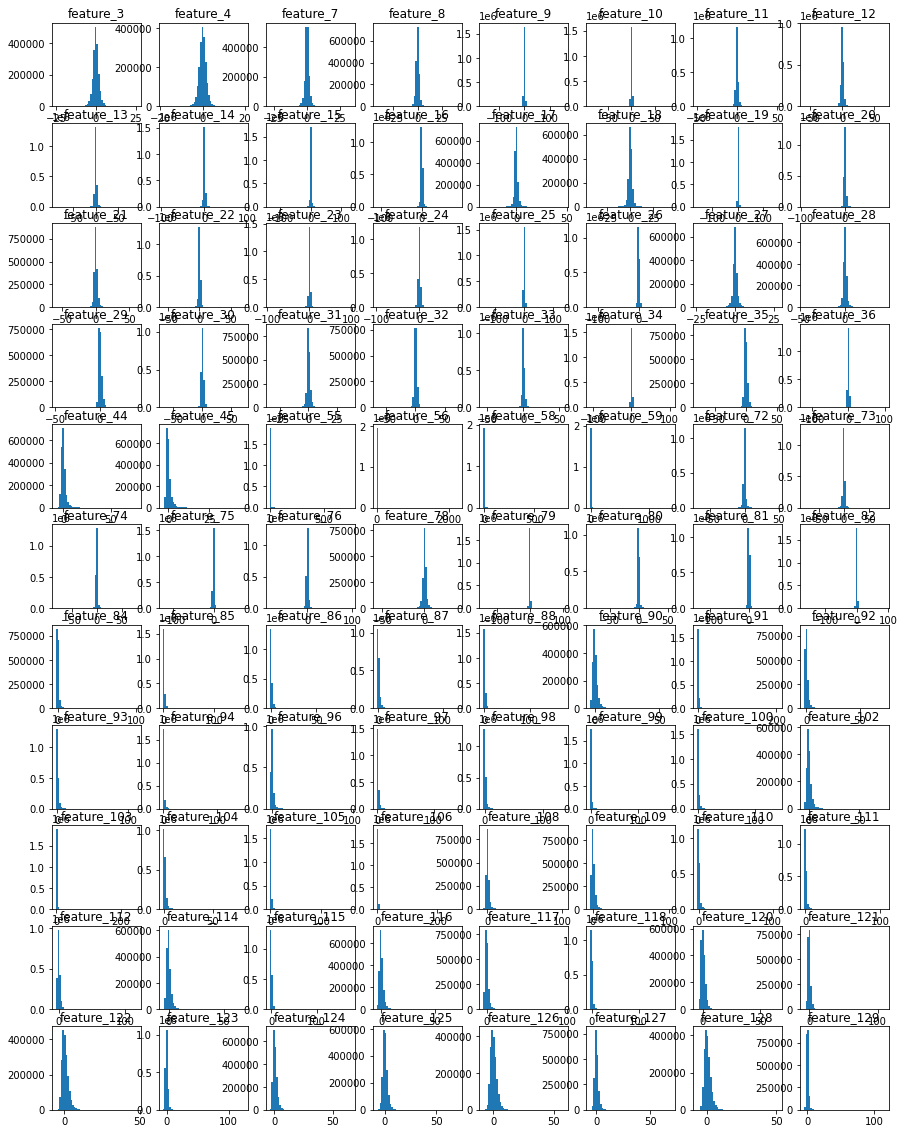

In [ ]:
## 欠損データの分布を確認する。
fss,axss = plt.subplots(11,8,figsize=(15,20))
n_i = len(axss)
n_j = len(axss[0])
for i in range(n_i):
  for j in range(n_j):
    axss[i][j].hist(df_train[feature_missing[i*n_j+j]],bins=50)
    axss[i][j].set_title(feature_missing[i*n_j+j])

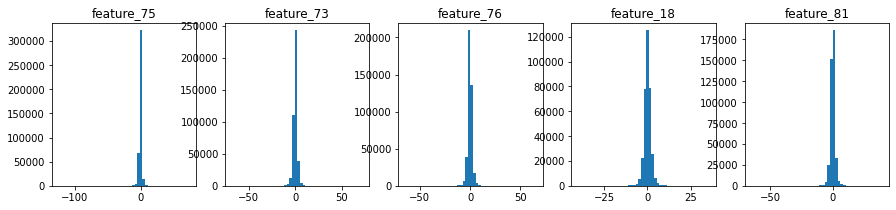

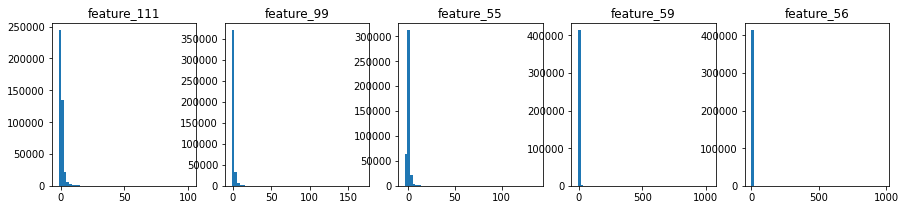

In [ ]:
## データ量が多いので、歪度が大きいもデータの分布を確認する。

##　skew値の算出
skews = df_train[feature_missing].skew()

## skew値の上位下位５つを確認する。
skews = skews.sort_values()
fs, axs = plt.subplots(1,5,figsize=(15,3))
for col,ax in zip(skews.index[:5],axs):
  ax.hist(df_train[col],bins=50)
  ax.set_title(col)

fs, axs = plt.subplots(1,5,figsize=(15,3))
for col,ax in zip(skews.index[-5:],axs):
  ax.hist(df_train[col],bins=50)
  ax.set_title(col)

単峰なので中央値で欠損を埋めて問題なさそう。

In [6]:
## 中央値で欠損を埋めて訓練データ候補として残す。
def func_fillna(df):
    features = df.columns[df.isna().sum()>0]
    
    for i in features:
      val_fill = df[i].median()
      df[i] = df[i].fillna(val_fill)

#     df = df.drop(features_drop,axis=1)
    
    return df

df_train = func_fillna(df_train)

In [ ]:
# ## 平均値で欠損を埋めて訓練データ候補として残す。
# def func_fillna(df):
#     features = df.columns[df.isna().sum()>0]
# #     features_drop = df.columns[df.isna().sum()>df.shape[0]*0.10]
# #     features = features.drop(features_drop)
    
#     for i in features:
#       val_fill = df[i].mean()
#       df[i] = df[i].fillna(val_fill)

# #     df = df.drop(features_drop,axis=1)
    
#     return df

# df_train = func_fillna(df_train)


In [9]:
## 主成分分析でデータの圧縮を試す
from sklearn.decomposition import PCA

features_pca = [x for x in df_train.columns if 'feature' in x]

pca = PCA()

values = pca.fit_transform(df_train[features_pca])

df_train_pca = pd.DataFrame(data = values,
                      columns = ["pca_{}".format(x+1) for x in range(len(features_pca))])

df_train_pca = pd.concat([df_train_pca, df_train[["action","resp"]].reset_index(drop=True) ],axis=1)


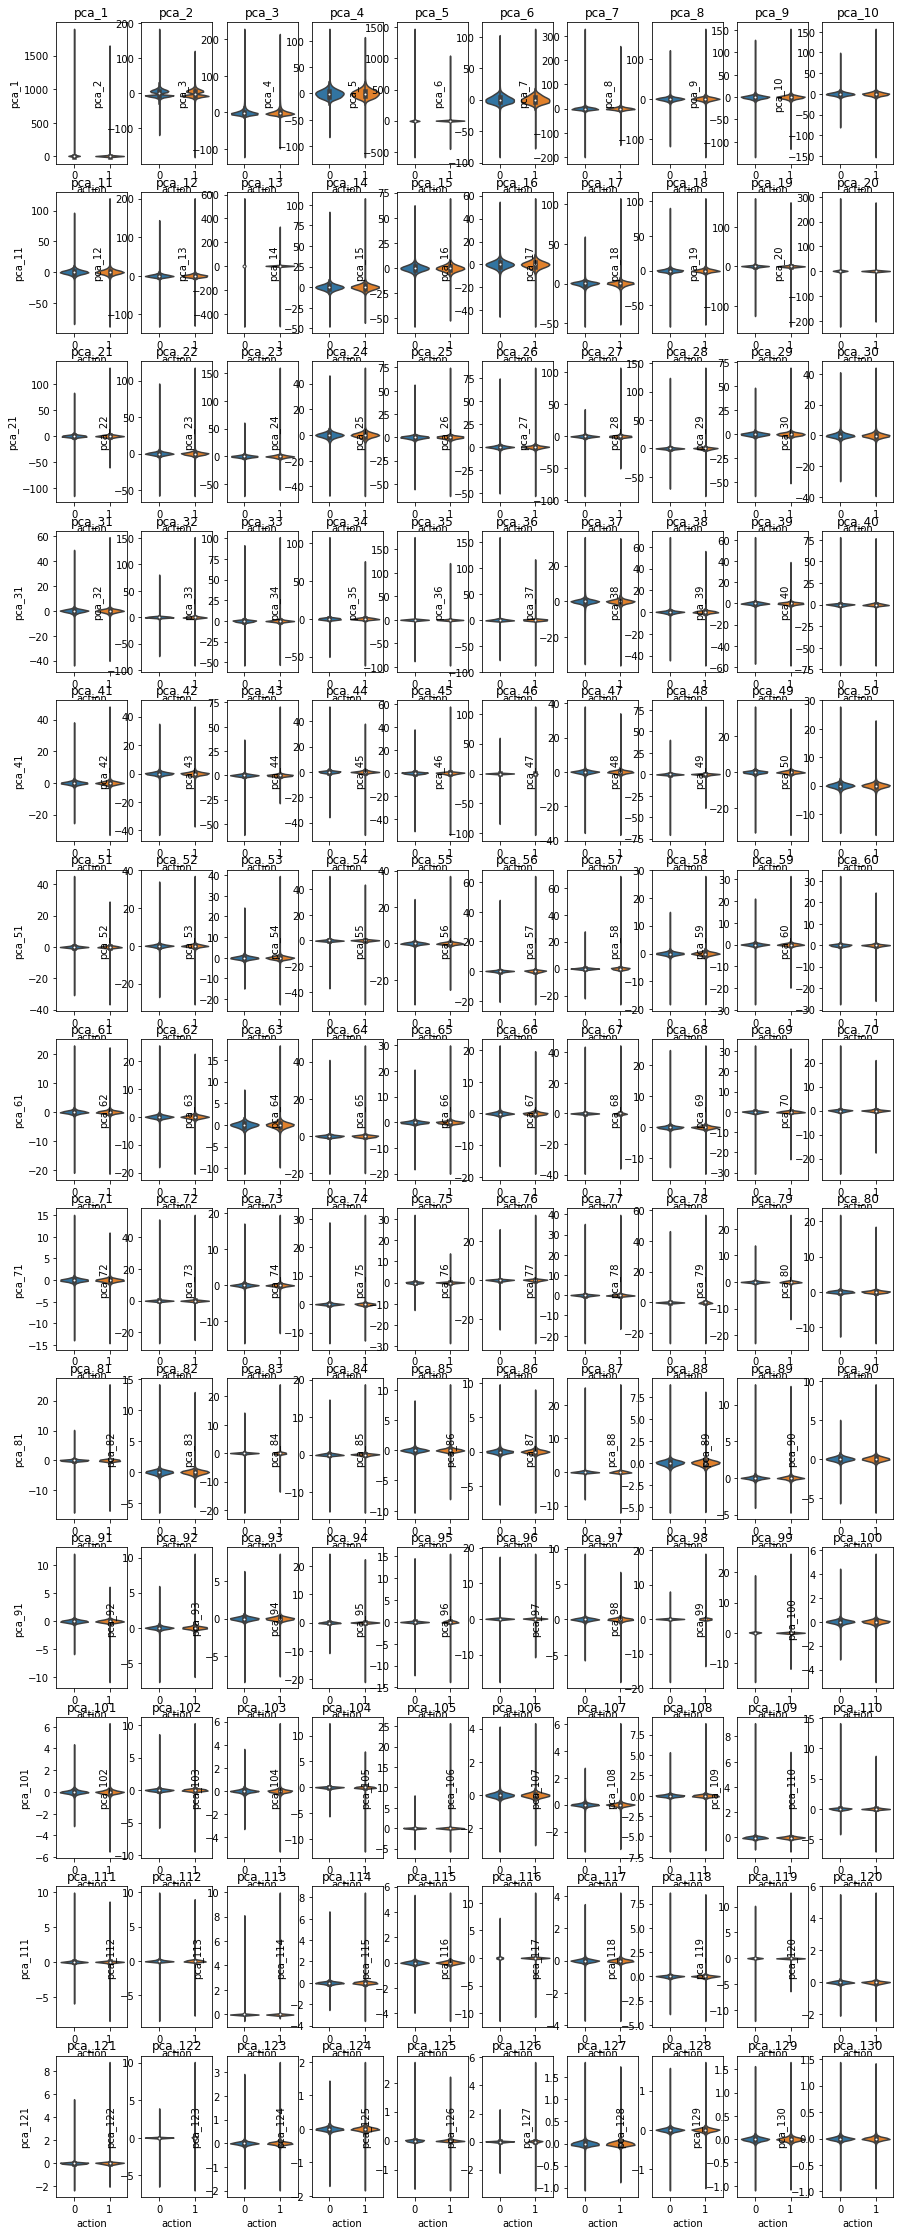

In [ ]:
### 主成分の分布を確認する
### action(リターンの正負（１，０）)で層別して、リターンの正負で分布に違いがあるか確認する。

def func_violin_hue(df, ax):
    ycol = df.columns[1]
    sns.violinplot(x="action",y=ycol, data = df,ax=ax)
    ax.set_title(ycol)


fss,axss = plt.subplots(13,10,figsize=(15,40))
n_i = len(axss)
# n_i = 1
n_j = len(axss[0])
# n_j = 10

for i in range(n_i):
  for j in range(n_j):
    func_violin_hue(df_train_pca[["action",f"pca_{i*n_j+j+1}"]], axss[i][j])
plt.show()

いくつかの主成分ではリターンの正負（action）に応じて分布が異なるが、概ね同じ分布。

In [10]:
### 特徴量抽出を試す。
### リターンの正負に対して相関係数が高い主成分を抽出する。
from sklearn.feature_selection import SelectKBest, f_classif, f_regression

selector = SelectKBest(score_func=f_regression, k=5)

cols_pca = [col for col in df_train_pca.columns if "pca" in col]

df_train_pca_selected = selector.fit_transform(df_train_pca[cols_pca], df_train_pca["action"])

In [12]:
selected_features = pd.DataFrame(selector.inverse_transform(df_train_pca_selected), 
                                 index=df_train_pca.index, 
                                 columns=cols_pca)
selected_features.head()

print("選ばれた特徴量上位５つ")
print(df_train_pca[cols_pca].columns[selector.get_support()])



選ばれた特徴量上位５つ
Index(['pca_2', 'pca_4', 'pca_8', 'pca_23', 'pca_29'], dtype='object')


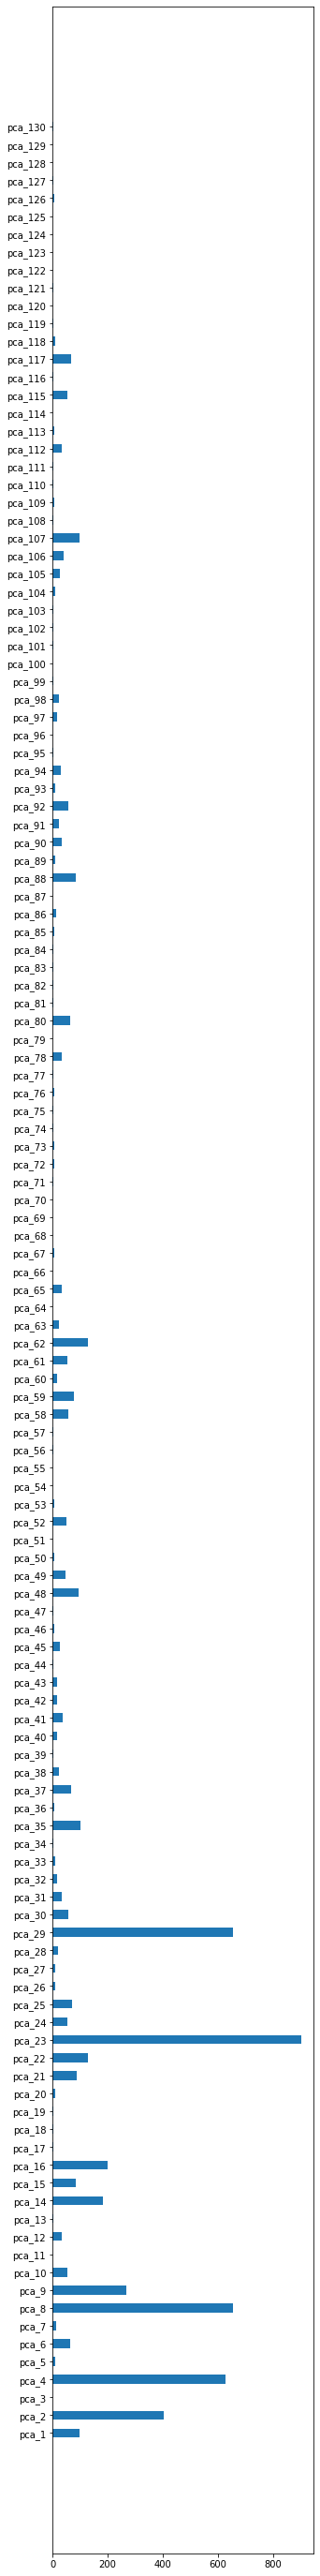

In [14]:
### リターンの正負(action)に対する各主成分の相関係数を棒グラフで示す。

plt.figure(figsize=(5,50))
height_val = selector.scores_
# left = np.arange(len(height_val))
labels = df_train_pca[cols_pca].columns
left = labels
height = 0.5
plt.barh(left, height_val, height=height)
# plt.yticks(left + height/2, labels)
plt.show()

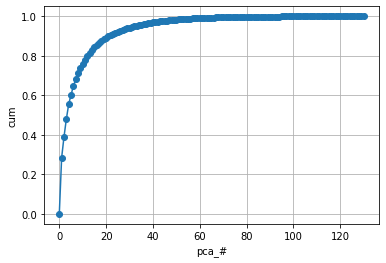

In [15]:
# モデルpcaの寄与率を算出
ev_ratio = pca.explained_variance_ratio_

# 寄与率をデータフレームに変換
df_evr = pd.DataFrame(data = ev_ratio, 
                      columns = ['pca'],
                      index = ["pca_{}".format(x+1) for x in range(len(features_pca))])

import matplotlib.pyplot as plt

# 寄与率を累積する
cc_ratio = np.cumsum(ev_ratio)

# 0を連結
cc_ratio = np.hstack([0, cc_ratio])

# グラフを描画
plt.plot(cc_ratio, "-o")
plt.xlabel("pca_#")
plt.ylabel("cum")
plt.grid()
plt.show()

主成分上位４０個でfeature_#の変動のほとんどを説明できそう

In [17]:
### Case1: 主成分上位２０個までを使うことにする。

cols_train = [f"pca_{x}" for x in range(1,21)]
X = df_train_pca[cols_train]
y = df_train["action"]
print(X.shape, y.shape)

(1958769, 20) (1958769,)


In [18]:
### Case2: リターンの正負(action)に対して相関が高い主成分上位２０個までを使うことにする。

df_pca_corr = pd.Series(data = selector.scores_, index= cols_pca)
# print(df_pca_corr)
# print("-"*20)
# print(df_pca_corr.sort_values(ascending=False)[:20])
cols_train = df_pca_corr.sort_values(ascending=False)[:20].index
print(cols_train)
X = df_train_pca[cols_train]
y = df_train["action"]
print(X.shape, y.shape)


Index(['pca_23', 'pca_8', 'pca_29', 'pca_4', 'pca_2', 'pca_9', 'pca_16',
       'pca_14', 'pca_62', 'pca_22', 'pca_35', 'pca_107', 'pca_1', 'pca_48',
       'pca_21', 'pca_15', 'pca_88', 'pca_59', 'pca_25', 'pca_37'],
      dtype='object')
(1958769, 20) (1958769,)


In [19]:
# 変数を標準化する
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

In [20]:
## モデル定義

import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

model = lgb.LGBMRegressor(n_estimator=500, learning_rate=0.3)

# model = lgb.LGBMRegressor()
# cv = KFold(shuffle=True, n_splits=5, random_state=108)
# params = {
#     'n_estimators':[500]
# #     'learning_rate':[0.1, 0.001, 0.5],
# #     'subsample':[1, 0.9],
# #     'feature_fraction':[1, 0.9]
# }

# clf = GridSearchCV(
#     estimator=model, 
#     scoring='neg_mean_squared_error',
#     cv = cv,
#     param_grid=params, 
#     verbose=10
# )

In [21]:
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.3, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimator=500, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [ ]:
df_valid = func_fillna(df_valid)
X_valid = pca.transform(df_valid[features_pca])
features_pca = [x for x in df_train.columns if 'feature' in x]
df_valid_pca = pd.DataFrame(data = X_valid,
                      columns = ["pca_{}".format(x+1) for x in range(len(features_pca))])
X_valid = df_valid_pca[cols_train]

X_valid = sc.transform(X_valid) ### ←　注意

y_valid = df_valid["action"]
y_pred = (model.predict(X_valid) > 0.5).astype(int)

In [ ]:
from sklearn import metrics
print(metrics.accuracy_score(y_pred, y_valid))

0.5292210675903721


History   


------   
訓練データ: 0~494日   
Model: n_estimator = 500, learning_rate = 0.3   
Model: pca上位２０個   
スコア： 0.5476951771915801

------   
訓練データ: 0~494日   
Model: n_estimator = 500, learning_rate = 0.3   
Model: pca上位２０個   
Model: StandardScalarで標準化   
スコア： 0.5477395861088906

------   


訓練データ: 0~494日   
Model: n_estimator = 500, learning_rate = 0.3   
Model: actionに対して相関が高いpca上位２０個   
スコア： 0.5456967759126032

------   


訓練データ: 0~494日   
Model: n_estimator = 500, learning_rate = 0.3   
Model: actionに対して相関が高いpca上位２０個   
Model: StandardScalarで標準化   
スコア： 0.5504485300648371

------   

訓練データ: 0~494日   
Model: n_estimator = 500, learning_rate = 0.3   
Model: actionに対して相関が高いpca上位２０個   
Model: StandardScalarで標準化   
スコア： 0.5292210675903721


# 時系列データ分析

In [23]:
### 日毎の計算
df_daymean = df_train.groupby("date").mean()
df_daymean.head()

,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,action
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.450830,-0.000009,0.000042,0.000532,0.002921,0.002367,-0.010941,0.833259,-0.535056,0.113492,0.022669,0.110890,0.041598,0.186546,-0.080537,0.982896,-0.339050,0.283631,-0.207039,0.583757,-0.238961,0.727726,-0.429440,0.166348,0.008803,0.398416,0.097931,0.329677,0.087982,0.387300,0.113211,0.398296,0.101906,0.268452,0.135827,0.534592,0.240261,0.373490,0.182412,0.518418,...,0.589627,0.544178,0.572018,0.710335,0.149217,0.235897,0.146965,0.202356,0.188518,0.189360,0.490860,0.533533,0.410840,0.406242,0.426814,0.598480,0.172513,0.082058,0.266839,0.232829,0.074220,0.230665,0.583421,0.647119,0.598107,0.601945,0.607149,0.583283,1.185025,-0.711828,1.191565,-0.502509,1.127214,-0.765732,1.472502,-0.552386,1.327694,-0.484735,2765.114661,0.513348
1,3.731454,0.000520,0.000453,-0.000085,-0.002049,-0.001500,-0.042171,0.545990,-0.604917,-0.025097,-0.048817,0.016629,-0.009931,0.146608,-0.081426,0.471781,-0.472771,0.194175,-0.229086,0.281863,-0.323560,0.350435,-0.613043,0.073873,-0.051035,0.265382,0.045529,0.129591,0.023487,0.219943,0.005843,0.254581,0.039411,0.278555,0.156144,0.482716,0.236079,0.355228,0.178247,0.462646,...,0.901210,0.809383,0.682691,1.774508,-0.049412,0.031847,-0.094437,-0.018365,0.022470,0.259388,1.170593,0.536140,0.795052,0.716779,0.632697,1.713957,-0.106115,-0.481308,-0.038571,-0.117334,-0.508294,0.261280,1.163107,0.659918,1.026937,0.952232,0.738499,1.509266,0.844428,-0.383390,0.817991,-0.299575,0.784457,-0.482749,0.987451,-0.360286,0.897811,-0.304326,10285.672234,0.505080
2,3.938793,-0.001259,-0.001259,-0.001138,-0.000958,-0.001075,-0.545455,-0.291139,-0.878971,-0.606301,-0.297191,-0.138462,0.059333,-0.476290,-0.507297,-0.484207,-0.701926,-0.246268,-0.673881,-1.435896,-1.353128,-0.335661,-0.998507,-0.991733,-1.204260,-0.568748,-0.835686,-1.936443,-1.126065,-1.837201,-2.203268,-1.081269,-1.282509,0.382952,0.438821,0.840701,0.726580,0.793331,0.842681,1.030542,...,2.607593,1.907701,1.237467,2.959266,1.175845,0.620070,1.701783,1.774462,0.815098,1.797925,2.325023,1.093691,2.378374,3.081298,2.044157,3.070723,1.661420,0.378602,1.399409,1.544673,0.965474,2.230138,2.155497,1.207774,3.110546,3.410984,1.965021,2.524715,0.186714,-1.136880,1.274304,1.651442,0.223182,-1.040913,0.739240,0.232813,1.237783,1.327631,15112.090909,0.409091
3,3.223618,-0.000303,-0.000512,-0.000804,-0.001840,-0.001771,-0.037739,0.756139,-0.164128,0.017892,-0.000260,0.145422,0.081462,0.118297,-0.029063,0.754595,-0.120291,0.248418,-0.040511,0.487251,-0.050217,0.569301,-0.171493,0.080354,-0.002405,0.301560,0.112877,0.181363,0.084641,0.268081,0.096194,0.310088,0.124399,0.261558,0.209604,0.564881,0.379506,0.455903,0.366337,0.608752,...,0.610852,0.515091,0.422761,0.870821,0.609444,0.328544,0.669631,0.533388,0.359798,0.904625,0.762466,0.371920,0.569184,0.498527,0.357046,0.796754,0.689595,0.223090,0.621234,0.493672,0.276143,0.934747,0.742010,0.345804,0.691441,0.602388,0.381712,0.747380,0.749577,0.450024,0.833048,0.412058,0.759684,0.503635,0.983807,0.418599,0.913954,0.394515,18778.785581,0.496192
4,3.300551,0.000594,0.000779,0.000676,

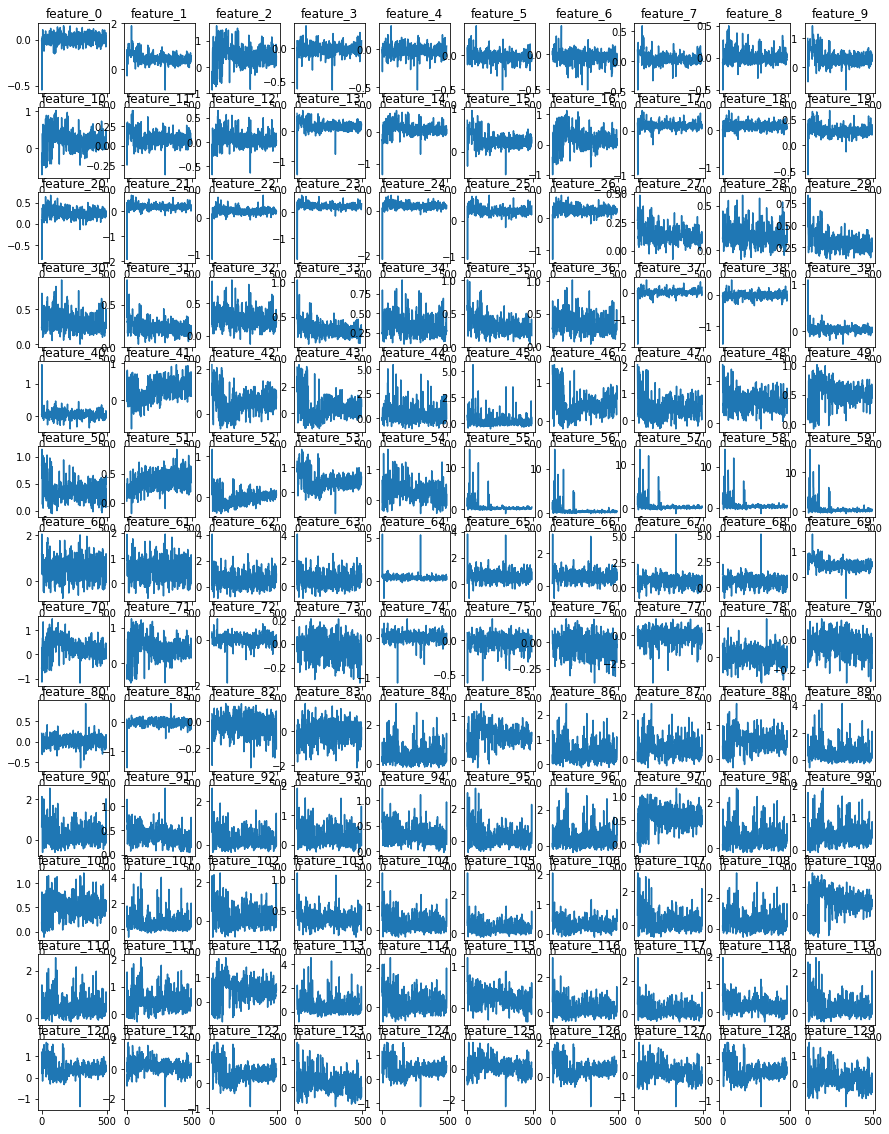

In [ ]:
### feature_#の日毎の平均値を確認する。

fss, axss = plt.subplots(13,10,figsize=(15,20))

cols = [col for col in df_daymean.columns if 'feature' in col]

num_i = len(axss)
num_j = len(axss[0])

# num_i = 2
# num_j = 2

for i in range(num_i):
    for j in range(num_j):

        axss[i][j].plot(df_daymean.index, df_daymean[cols[i*num_j+j]])
        axss[i][j].set_title(cols[i*num_j+j])


*   トレンドがある。→　移動平均、階差で過去データを考慮するとよいのでは？
*   似ている波形がある。→　日足はいくつかの大きな背景要因に支配されていそう。→　主成分分析で効率よく変数を圧縮できそう。

--------------------
feature_4


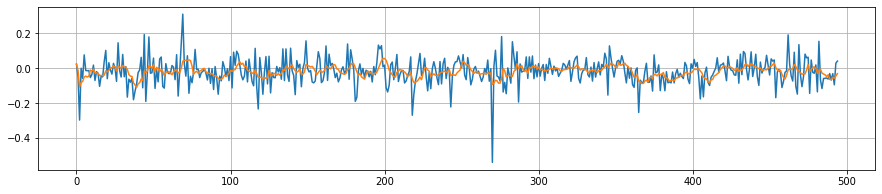

--------------------
resp


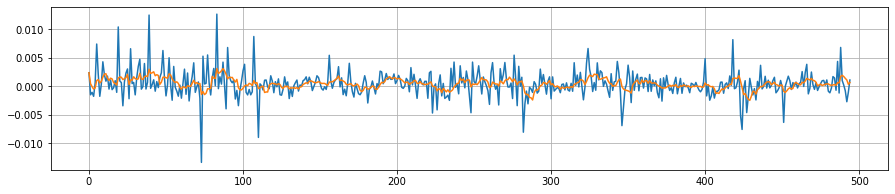

In [ ]:
### ７日移動平均を確認
print("-"*20)
col = "feature_4"
print(col)
plt.figure(figsize=(15,3))
plt.plot(df_daymean.loc[0:500,col])
plt.plot(df_daymean.loc[0:500,col].rolling(window=7,min_periods=1).mean())
plt.grid()
plt.show()


print("-"*20)
col = "resp"
print(col)
plt.figure(figsize=(15,3))
plt.plot(df_daymean.loc[0:500,col])
plt.plot(df_daymean.loc[0:500,col].rolling(window=7,min_periods=1).mean())
plt.grid()
plt.show()


7日移動平均でトレンドを再現できている。

In [24]:
### 移動平均、階差１，階差２、階差３を計算

cols_feature = [f"feature_{i}" for i in range(130)]
cols_roll = [f"feature_{i}_roll" for i in range(130)]
cols_diff = [f"feature_{i}_diff" for i in range(130)]
cols_diff2 = [f"feature_{i}_diff2" for i in range(130)]

df_daymean_roll = df_daymean[cols_feature].rolling(window=7,min_periods=1).mean().add_suffix("_roll")
df_daymean_diff = df_daymean[cols_feature].diff(periods=1,axis=0).add_suffix('_diff')
df_daymean_diff.iloc[0]=0
df_daymean_diff2 = df_daymean_diff[cols_diff].diff(periods=1,axis=0).add_suffix('2')
df_daymean_diff2.iloc[0]=0
df_daymean_diff3 = df_daymean_diff2[cols_diff2].diff(periods=1,axis=0).add_suffix('3')
df_daymean_diff3.iloc[0]=0

In [ ]:
# df_daymean = pd.concat([df_daymean,df_daymean_roll,df_daymean_diff],axis=1)

In [25]:
## 主成分分析
from sklearn.decomposition import PCA



def check_pca(df):
  cols = [col for col in df.columns if "feature" in col]

  pca = PCA()
  values = pca.fit_transform(df[cols])
  ev_ratio = pca.explained_variance_ratio_

  df_pca = pd.DataFrame(data = values,
                      columns = ["pca_{}".format(x+1) for x in range(len(cols))])

  # 寄与率を累積する
  cc_ratio = np.cumsum(ev_ratio)

  # 0を連結
  cc_ratio = np.hstack([0, cc_ratio])
  

  return cc_ratio,pca,df_pca


cols_feature = [col for col in df_daymean.columns if "feature" in col]
cc_ratio_daymean, pca_daymean, df_daymean_pca = check_pca(df_daymean[cols_feature]) 
cc_ratio_roll, pca_roll, df_daymean_roll_pca = check_pca(df_daymean_roll) 
cc_ratio_diff, pca_diff, df_daymean_diff_pca = check_pca(df_daymean_diff) 
cc_ratio_diff2, pca_diff2, df_daymean_diff2_pca = check_pca(df_daymean_diff2) 
cc_ratio_diff3, pca_diff3, df_daymean_diff3_pca = check_pca(df_daymean_diff3) 

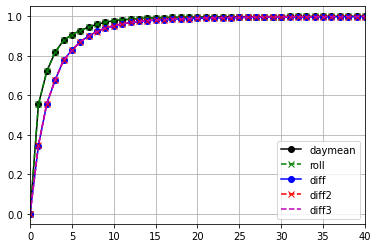

In [26]:
plt.plot(cc_ratio_roll,"-ok",label="daymean")
plt.plot(cc_ratio_roll,"--xg",label="roll")
plt.plot(cc_ratio_diff,"-ob",label="diff")
plt.plot(cc_ratio_diff2,"--xr",label="diff2")
plt.plot(cc_ratio_diff2,"--m",label="diff3")
plt.xlim([0,40])
plt.legend()
plt.grid()
plt.show()

* 1日平均、移動平均、階差１,2,3は主成分１０個くらいで説明できそう。
* 階差１，２，３に変化なし。

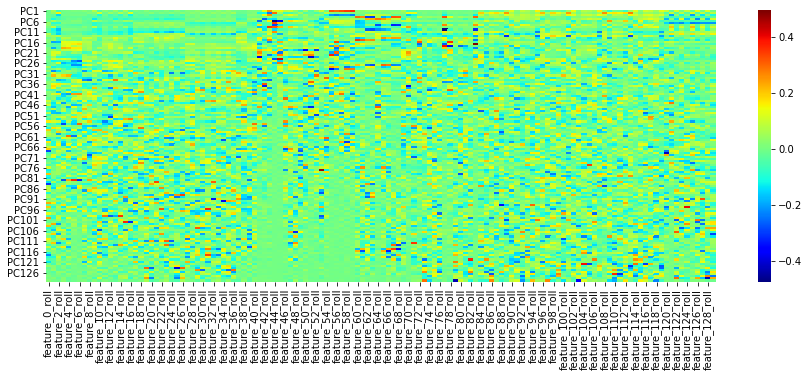

In [ ]:
### 主成分を構成するfeature_#を可視化してみる

df = df_daymean_roll
pca = pca_roll

df_eigen = pd.DataFrame(pca.components_, columns=df.columns, index=["PC{}".format(x + 1) for x in range(len(df.columns))])

plt.figure(figsize=(15,5))
sns.heatmap(df_eigen,cmap="jet")

feature42-46, feature56-60あたりが主成分を構成している。

--------------------
daymean_pca：1日平均主成分１


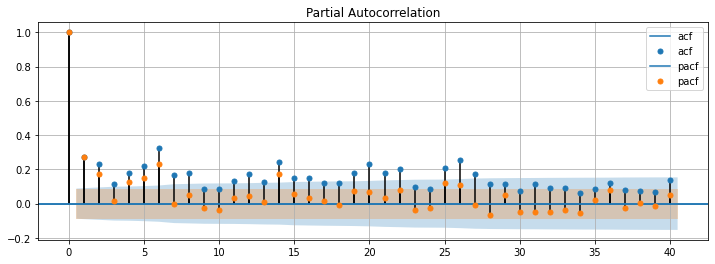

--------------------
roll_pca：移動平均主成分１


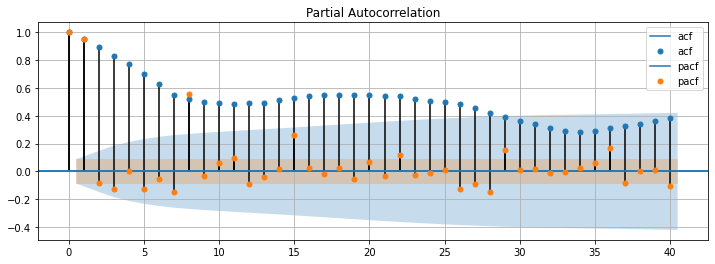

--------------------
roll_diff：移動平均階差１主成分１


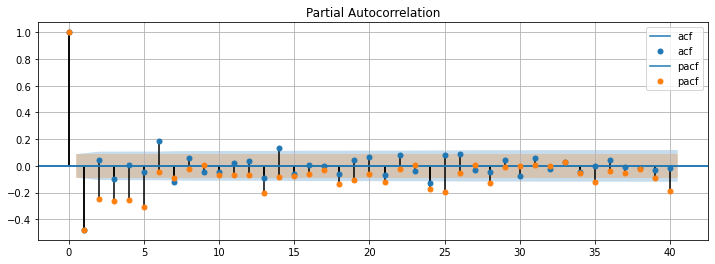

--------------------
roll_diff2：移動平均階差２主成分１


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


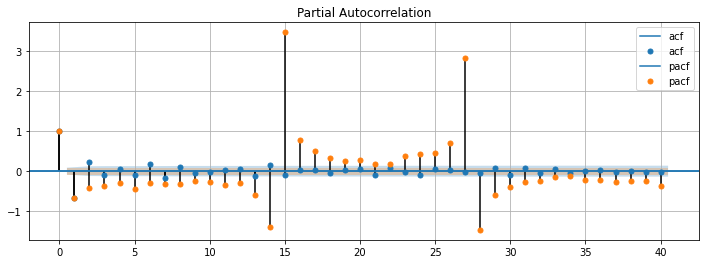

--------------------
resp：リターン値


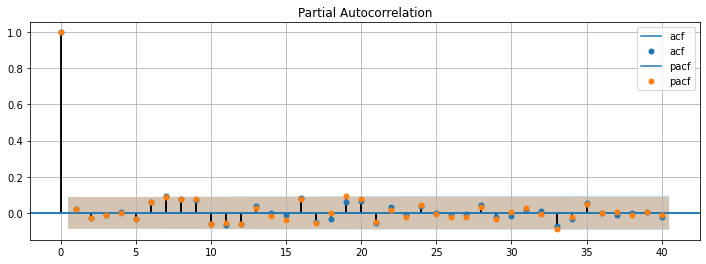

In [ ]:
### コレログラム確認

import statsmodels.api as sm

def check_acf(data1):
    # print(sm.tsa.stattools.acf(data1, nlags=40))
    # 自己相関(ACF)のグラフ自動作成
    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(111)
    sm.graphics.tsa.plot_acf(data1, lags=40, ax=ax1,label="acf")
    sm.graphics.tsa.plot_pacf(data1, lags=40, ax=ax1,label="pacf")
    plt.legend()
    plt.grid()
    plt.show()

print("-"*20)
print("daymean_pca：1日平均主成分１")
check_acf(df_daymean_pca["pca_1"])
print("-"*20)
print("roll_pca：移動平均主成分１")
check_acf(df_daymean_roll_pca["pca_1"])
print("-"*20)
print("roll_diff：移動平均階差１主成分１")
check_acf(df_daymean_diff_pca["pca_1"])
print("-"*20)
print("roll_diff2：移動平均階差２主成分１")
check_acf(df_daymean_diff2_pca["pca_1"])
print("-"*20)
print("resp：リターン値")
check_acf(df_daymean["resp"])




*   1日平均値は過去２日間のデータの影響を受けている。
* リターン値は過去のリターン値の影響を受けない。リターンはfeature_#から推測してよい。
* １階差は前日に対して相関-0.4で影響を受けている。



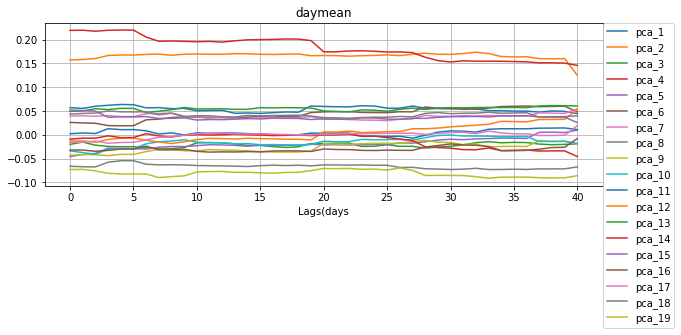

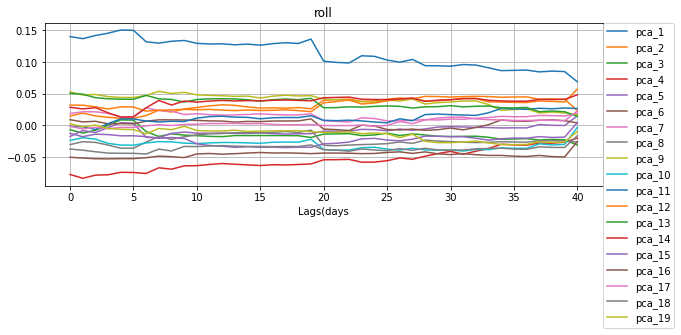

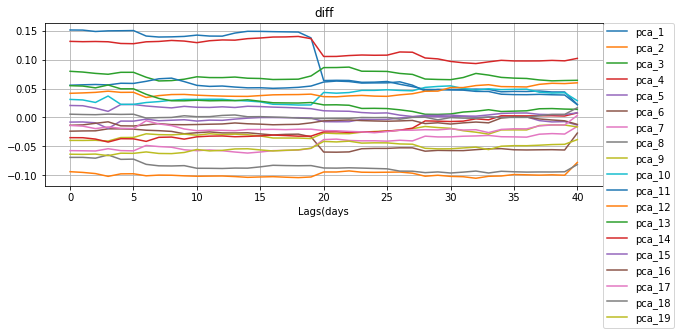

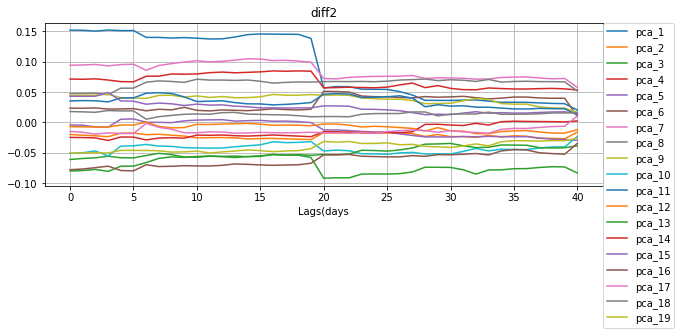

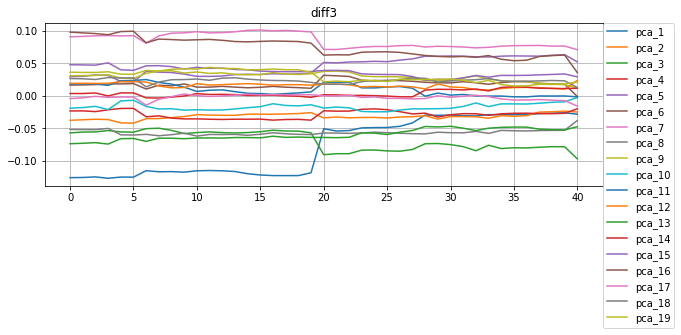

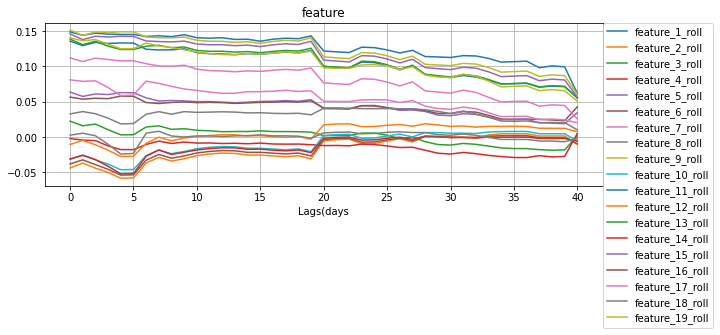

In [ ]:
### ２変数のコレログラフを作成する
### リターン値(Resp)に対して、１日平均(daymean)、移動平均(roll)、1階差(diff1)の影響を確認する。

def check_transient_corr(data1,data2):
  nlag = 40
  corr = np.empty(nlag+1)
  
  corr[0] = np.sum((data1-data1.mean())*(data2-data2.mean()))
  corr[0] = corr[0] / np.sqrt(np.sum((data1-data1.mean())**2)) / np.sqrt(np.sum((data2-data2.mean())**2))
  for i in range(1,nlag+1):
    corr[i] = np.sum((data1[i:]-data1.mean())*(data2[:-i]-data2.mean()))
    corr[i] = corr[i] / np.sqrt(np.sum((data1-data1.mean())**2)) / np.sqrt(np.sum((data2-data2.mean())**2))

  return corr



corrs=[]
plt.figure(figsize=(10,3))
for ipca in range(1,20):
  corr = check_transient_corr(df_daymean["resp"], df_daymean_pca[f"pca_{ipca}"])
  corrs.append(corr)
  plt.plot(corr, label=f"pca_{ipca}")
plt.title("daymean")
plt.xlabel("Lags(days")
plt.grid()
plt.legend( bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, fontsize=10 )
plt.show()

corrs=[]
plt.figure(figsize=(10,3))
for ipca in range(1,20):
  corr = check_transient_corr(df_daymean["resp"], df_daymean_roll_pca[f"pca_{ipca}"])
  corrs.append(corr)
  plt.plot(corr, label=f"pca_{ipca}")
plt.title("roll")
plt.xlabel("Lags(days")
plt.grid()
plt.legend( bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, fontsize=10 )
plt.show()


corrs=[]
plt.figure(figsize=(10,3))
for ipca in range(1,20):
  corr = check_transient_corr(df_daymean["resp"], df_daymean_diff_pca[f"pca_{ipca}"])
  corrs.append(corr)
  plt.plot(corr, label=f"pca_{ipca}")
plt.title("diff")
plt.xlabel("Lags(days")
plt.grid()
plt.legend( bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, fontsize=10 )
plt.show()


corrs=[]
plt.figure(figsize=(10,3))
for ipca in range(1,20):
  corr = check_transient_corr(df_daymean["resp"], df_daymean_diff2_pca[f"pca_{ipca}"])
  corrs.append(corr)
  plt.plot(corr, label=f"pca_{ipca}")
plt.title("diff2")
plt.xlabel("Lags(days")
plt.grid()
plt.legend( bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, fontsize=10 )
plt.show()

corrs=[]
plt.figure(figsize=(10,3))
for ipca in range(1,20):
  corr = check_transient_corr(df_daymean["resp"], df_daymean_diff3_pca[f"pca_{ipca}"])
  corrs.append(corr)
  plt.plot(corr, label=f"pca_{ipca}")
plt.title("diff3")
plt.grid()
plt.legend( bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, fontsize=10 )
plt.show()

corrs=[]
plt.figure(figsize=(10,3))
for ipca in range(1,20):
  corr = check_transient_corr(df_daymean["resp"], df_daymean_roll[f"feature_{ipca}_roll"])
  corrs.append(corr)
  plt.plot(corr, label=f"feature_{ipca}_roll")
plt.title("feature")
plt.xlabel("Lags(days")
plt.grid()
plt.legend( bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, fontsize=10 )
plt.show()

* リターン値に対する1日平均の相関は過去５日間までは同程度（pca_4）。

* リターン値に対する移動平均、階差１は過去２０日間で緩やかに減少し、前日２０日を堺に急激に減少する。

* 20日以上経過すると、相関が急激に小さくなる。→　２０日前以上のデータは使用する必要なし。

* 前日５日間はほとんど同じ相関を保っているので、特徴量は直前日の1日平均、移動平均、階差１で十分でと予想。

In [32]:
df_train.isna().any()

date           False
weight         False
resp_1         False
resp_2         False
resp_3         False
               ...  
feature_127     True
feature_128     True
feature_129     True
ts_id          False
action         False
Length: 139, dtype: bool

In [59]:
filter.sum()

0

Text(0.5, 1.0, 'Missing value of feature_11 at days from 101 to 109')

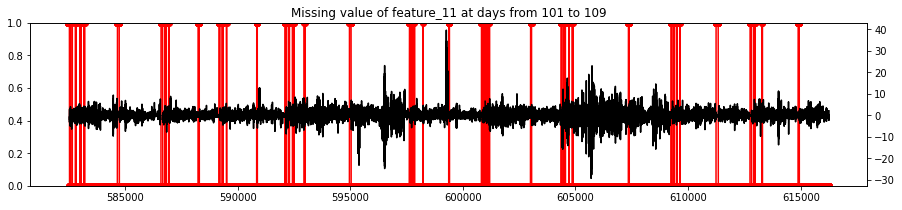

In [77]:
### 欠損値がいつ起きているかを確認する

col = "feature_11"
filter = (df_train['date']>100) & (df_train['date']<110)
# filter = (df_train.index > 1.883*10**6) & (df_train.index < 1.886*10**6)


x = df_train[filter][col].isna().astype(int)
y = df_train[filter][col]
f, ax = plt.subplots(figsize=(15,3))
ax.plot(x,"-or")
ax.set_ylim([0,1])
ax2 = ax.twinx()
ax2.plot(y,"-k")
ax.set_title(f'Missing value of {col} at days from {df_train[filter]["date"].min()} to {df_train[filter]["date"].max()}')

欠損値が発生するタイミングに規則性が見えないので、１日平均値で埋めて問題ないと判断。

# 時系列モデル作成

コンペでは各時刻のデータがfor文で刻々と与えられ予測していくスタイル。
コードが煩雑になるのを防ぐためpipelineで一連の処理をまとめた。      
      
----     



モデルの流れ   
　　　             
欠損値を１日平均値で埋める　　       
↓          
瞬時データ、移動平均７日間、階差１から主成分を計算　　　      
↓   
学習   　　　

In [ ]:
## 前処理クラス作成

from sklearn.base import BaseEstimator, TransformerMixin

## pipelineで処理できるようにベースとなるクラスの定義
class skPlumberBase(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return self

## pipelineベースクラスを継承して自作前処理クラスを作成する。

### １日平均、移動平均、階差１を算出して保存
class PreProcessor0(skPlumberBase):
    cols_feature = [f"feature_{i}" for i in range(130)]
    cols_roll = [f"feature_{i}_roll" for i in range(130)]
    cols_diff = [f"feature_{i}_diff" for i in range(130)]
    def fit(self,df,y=None):
        df_daymean = df.groupby('date').mean()
        df_daymean_roll = df_daymean[cols_feature].rolling(window=7,min_periods=1).mean().add_suffix("_roll")
        df_daymean_diff = df_daymean[cols_feature].diff(periods=1,axis=0).add_suffix('_diff')
        df_daymean_diff.iloc[0]=0
        df_daymean = pd.concat([df_daymean,df_daymean_roll,df_daymean_diff],axis=1)
        self.df_daymean = df_daymean
        self.df_daymean_roll = df_daymean_roll
        self.df_daymean_diff = df_daymean_diff
        return self

### 欠損データを一日平均値で埋める。（計算が遅いので使用しない）
    def transform_train(self,df,y=None):
        # df_tmp = df.copy()
        df_tmp = pd.DataFrame(data=[],columns=df.columns)
        for day in df['date'].unique():
            print(f"fitting to day:{day}")
            # df.loc[df['date']==day,:] = df.loc[df['date']==day,:].fillna(self.df_daymean.loc[day])
            # df.loc[df['date']==day,:].fillna(self.df_daymean.loc[day])
            df_tmp = pd.concat([df_tmp,df.loc[df['date']==day,:].fillna(self.df_daymean.loc[day])],axis=0)
            # df_tmp = pd.concat([df_tmp,df.loc[df['date']==day,:].fillna(method="bfill").fillna(method="ffill")],axis=0)
            # df_tmp = pd.concat([df_tmp,df.loc[df['date']==day,:].fillna(0)],axis=0)
        df_tmp = pd.merge(df_tmp,self.df_daymean[cols_roll+cols_diff],on='date')
        return df_tmp

### 欠損データを一日平均値で埋める。(訓練データ用)
    def transform_train2(self,df,y=None):
        for day in df["date"].unique():
            print(f"fitting to day:{day}")
            df.loc[df['date']==day,:] = df[df["date"]==day].fillna(self.df_daymean.loc[day])
        df = pd.merge(df,self.df_daymean[cols_roll+cols_diff],on='date')
        return df
### 欠損データを一日平均値で埋める。（前日の平均値で埋める）(評価データ用)
    def transform(self,df,y=None):
        df_tmp = df.copy()
        for col in (cols_roll+cols_diff):
            df_tmp[col] = self.df_daymean.iloc[-1][col]
        for col_feature, col_roll in zip(cols_feature,cols_roll):
            df_tmp[col_feature] = df_tmp[col_feature].fillna(self.df_daymean.iloc[-1][col_roll])
        return df_tmp
    def get_daymean(self):
        return self.df_daymean, self.df_daymean_roll, self.df_daymean_diff


In [ ]:
### 主成分分析クラスの定義
### パイプラインが利用できるようにPCAクラスを継承上書き
from sklearn.decomposition import PCA

class myPCA(PCA):
    def fit(self,X,y=None):
        return super().fit(X)
    def transform(self,X,y=None):
        return super().transform(X)

In [ ]:
## モデル定義

import lightgbm as lgb

clf = lgb.LGBMRegressor(random_state=0,n_estimators=500,learning_rate=0.3)

In [ ]:
## パイプライン結合

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

cols_feature = [f"feature_{i}" for i in range(130)]
cols_roll = [f"feature_{i}_roll" for i in range(130)]
cols_diff = [f"feature_{i}_diff" for i in range(130)]

preprocessor0 = PreProcessor0()

pca_transformer_feature = myPCA(n_components=20)
pca_transformer_roll = myPCA(n_components=20)
pca_transformer_diff = myPCA(n_components=20)

preprocessor1 = ColumnTransformer(
    transformers=[
        ('pca_feature', pca_transformer_feature, cols_feature),
        ('pca_roll', pca_transformer_roll, cols_roll),
        ('pca_diff', pca_transformer_diff, cols_diff),      
    ],
    )

model = Pipeline(steps=[('preprocessor1', preprocessor1),
                        ('clf', clf)
                             ])

In [ ]:
### 前処理：　１日平均、移動平均、階差１を算出
preprocessor0.fit(df_train)

PreProcessor0()

In [ ]:
### 欠損を埋める
df_train = preprocessor0.transform_train2(df_train)

In [ ]:
print(df_train.shape)

(414405, 399)


In [ ]:
X_train = df_train[cols_feature+cols_roll+cols_diff]
y_train = df_train['action']

In [ ]:
model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor1',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pca_feature',
                                                  myPCA(copy=True,
                                                        iterated_power='auto',
                                                        n_components=20,
                                                        random_state=None,
                                                        svd_solver='auto',
                                                        tol=0.0, whiten=False),
                                                  ['feature_0', 'feature_1',
                                                   'feature_2', 'feature_3',
                                                   'feature_4', 'feature_5...
              

In [ ]:
cols_feature = [f"feature_{i}" for i in range(130)]
cols_roll = [f"feature_{i}_roll" for i in range(130)]
cols_diff = [f"feature_{i}_diff" for i in range(130)]

df_valid_pre = preprocessor0.transform(df_valid)
X_valid = df_valid_pre[cols_feature+cols_roll+cols_diff]
y_valid = df_valid['action']

In [ ]:
X_valid.shape

(22518, 390)

In [ ]:
y_pred = (model.predict(X_valid) > 0.5).astype(int)
y_pred_baseline = np.ones(len(y_pred))  ### ベースラインは全部１と予想する。

In [ ]:
from sklearn import metrics
print("baseline score:")
print(metrics.accuracy_score(y_pred_baseline, y_valid))
print("-"*20)
print("my model score:")
print(metrics.accuracy_score(y_pred, y_valid))

baseline score:
0.5127897681854516
--------------------
my model score:
0.5396127542410516


History 

---     

Days: 300-494   
Model: LGB(n_estimator=100,lerning_rate=0.3)  
Model: feature_col_pca:10, roll_pca:15, diff_pca:15  
Score: 0.5317967847943867  

---     

Days: 400-494   
Model: LGB(n_estimator=300,lerning_rate=0.3)  
Model: feature_col_pca:10, roll_pca:15, diff_pca:15  
Score: 0.5371258548716582 

---     

Days: 400-494   
Model: LGB(n_estimator=300,lerning_rate=0.3)  
Model: feature_col_pca:20, roll_pca:15, diff_pca:15  
Score: 0.5432986943778311 


---     

Days: 400-494   
Model: LGB(n_estimator=300,lerning_rate=0.3)  
Model: feature_col_pca:40, roll_pca:15, diff_pca:15  
Score: 0.5370370370370371


---     

Days: 400-494   
Model: LGB(n_estimator=300,lerning_rate=0.3)  
Model: feature_col_pca:20, roll_pca:20, diff_pca:20  
Score: 0.5429434230393463


---     

Days: 400-494   
Model: LGB(n_estimator=500,lerning_rate=0.3)  
Model: feature_col_pca:20, roll_pca:20, diff_pca:20  
Score: 0.5396127542410516

In [ ]:
## モデル評価関数（使用しなくて良い）

def get_score_transient(df_train,df_valid):
    cols = [col for col in df_train.columns if 'feature' in col]
    valid_size = len(df_valid)
    y_pred=[]
    for i in range(valid_size):
      print(f"{i}/{valid_size}")
      df_train = pd.concat([df_train,df_valid[:i+1]],axis=0)
      preprocessor.fit(df_train[cols])
      X = preprocessor.transform(df_train[cols])
      y_pred.append((model.predict(X[-1:]) > 0.5).astype(int))
      y_valid = df_valid["action"]

    score = 1-np.sum(np.abs(y_pred-y_valid)) # 全問正解＝1.0

    return score


def get_score_steady(df_valid):
    cols = [col for col in df_valid.columns if 'feature' in col]
    y_pred = (model.predict(df_valid[cols]) > 0.5).astype(int)
    y_valid = df_valid["action"]

    score = 1-np.sum(np.abs(y_pred-y_valid))/len(y_valid) # 全問正解＝1.0

    return score,y_pred,y_valid